In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import numpy as np
import pandas as pd
from hyperband import Hyperband
from evaluators import TorchEvaluator
from sampler import Sampler
from utils.sr_calculators import TorchCalculator
from sklearn.model_selection import train_test_split
from constraints.constraints_executor import NumpyConstraintsExecutor
from constraints.url_constraints import get_url_relation_constraints
from constraints.relation_constraint import AndConstraint
from ml_wrappers import wrap_model
from utils.model import Net
import timeit
import joblib
import pickle
import warnings
warnings.filterwarnings(action='ignore')

c:\Users\ayoub.belouadah\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hello 12768 from Hyperband


In [2]:
scaler = preprocessing_pipeline = joblib.load('./ressources/baseline_scaler.joblib')
x_clean = np.load('./ressources/baseline_X_test_candidates.npy')
y_clean = np.load('./ressources/baseline_y_test_candidates.npy')
x_clean = scaler.transform(x_clean)
metadata = pd.read_csv('./ressources/url_metadata.csv')
min_constraints = metadata['min'].to_list()[:63]
max_constraints = metadata['max'].to_list()[:63]
features_min_max = (min_constraints, max_constraints)

constraints = get_url_relation_constraints()
executor = NumpyConstraintsExecutor(AndConstraint(constraints))

model = Net()
model = torch.load('./ressources/model_url.pth')
model = wrap_model(model, x_clean, model_task='classification')

    # Parameters for Hyperband
dimensions = x_clean.shape[1]
BATCH_SIZE = 1#x_clean.shape[0]
eps = 0.2
downsample = 2
sampler = Sampler()
distance = 2
classifier_path = './ressources/model_url.h5'
seed = 202374
success_rates_l2 = []
exec_times_l2 = []

R_values = [390]
history_dict = dict()

In [3]:
for R in R_values:
        url_evaluator = TorchEvaluator(constraints=constraints, scaler=scaler, alpha=1.0, beta=1.0)
        scores, configs, candidates = [], [], []
        start = timeit.default_timer()
        
        hp = Hyperband(objective=url_evaluator, classifier=model, x=x_clean[:BATCH_SIZE], y=y_clean[:BATCH_SIZE], sampler=sampler, eps=eps, dimensions=dimensions, max_configuration_size=dimensions-1, R=R, downsample=downsample, distance=distance, seed=seed)
        scores, configs, candidates, history = hp.generate(mutables=None, features_min_max=(0,1))

        end = timeit.default_timer()
        print(f'Exec time {round((end - start) / 60, 3)}')
        success_rate_calculator = TorchCalculator(classifier=model, data=x_clean[:BATCH_SIZE], labels=y_clean[:BATCH_SIZE], scores=np.array(scores), candidates=candidates)
        success_rate, best_candidates, adversarials = success_rate_calculator.evaluate()
        print(f'success rate {success_rate}, len best_candidates {len(best_candidates)}, len adversarials {len(adversarials)}')
        #adversarials, best_candidates = scaler.inverse_transform(np.array(adversarials)), scaler.inverse_transform(np.array(best_candidates))
        #print(f'\n Execution Time {round((end - start) / 60, 3)}\n')
        #print(f'Success rate over {BATCH_SIZE} examples (M) : {success_rate * 100}')
        #print(f'len adversarials {len(adversarials)}')
        #violations = np.array([executor.execute(adv[np.newaxis, :])[0] for adv in adversarials])
        #violations_candidates = np.array([executor.execute(adv[np.newaxis, :])[0] for adv in best_candidates])
        #tolerance = 0.0001
        #satisfaction = (violations < tolerance).astype('int').sum()
        #satisfaction_candidates = (violations_candidates < tolerance).astype('int').sum()
        #print(f'Constraints satisfaction (C&M) {(success_rate * 100) - satisfaction}')
        #history_dict[R] = {'M': round(success_rate * 100, 2), 'C&M': round((satisfaction * 100) / BATCH_SIZE, 2), 'C': round((satisfaction_candidates * 100) / len(best_candidates), 2), 'Execution time': round((end - start) / 60, 3)}

Hyperband brackets 9
Exec time 0.793
success rate 0.0, len best_candidates 1, len adversarials 0


In [4]:
for i, k in enumerate(history[0]):
    if i == 16:
        print(round(min(history[0][k]), 3))

0.276


In [5]:
scores

[[0.546,
  0.546,
  0.546,
  0.546,
  0.546,
  0.546,
  0.97,
  0.958,
  0.976,
  0.954,
  0.975,
  0.979,
  0.988]]

In [7]:
import matplotlib.pyplot as plt


In [13]:
histories = history[0]
max_length = 0
c = None
for k in histories:
    if len(histories[k]) > max_length:
        max_length = len(histories[k])
        c = k
print(max_length)
print(c)
print(histories[c])

121
(4, 39)
[0.5653643012046814, 0.6082510352134705, 0.8102559447288513, 0.7860321998596191, 0.7821486592292786, 0.7276909947395325, 0.5744267702102661, 0.6919456720352173, 0.8627212643623352, 0.7936331033706665, 0.6096835732460022, 0.7970449328422546, 0.7209566831588745, 0.9166764616966248, 0.8262199759483337, 0.7751749157905579, 0.7333185076713562, 0.8371567130088806, 0.6961900591850281, 0.8110783100128174, 0.6835347414016724, 0.8952347040176392, 0.8180554509162903, 0.7022445797920227, 0.7655426263809204, 0.8337991237640381, 0.8850825428962708, 0.6747527718544006, 0.8865429759025574, 0.8633890151977539, 0.7974134683609009, 0.6633962392807007, 0.812260627746582, 0.6366716027259827, 0.6220076084136963, 0.5646605491638184, 0.7417821288108826, 0.6945077776908875, 0.8947479128837585, 0.8200072050094604, 0.758490800857544, 0.7312555313110352, 0.6451418995857239, 0.6973578333854675, 0.615216851234436, 0.7637564539909363, 0.87288898229599, 0.7238724231719971, 0.7510290145874023, 0.5932314395

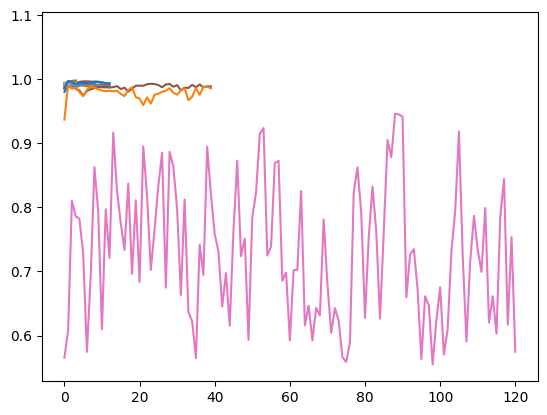

In [14]:
for k in histories:
    plt.plot(list(range(len(histories[k]))), histories[k])

In [15]:
scores

[[0.555, 0.557, 0.979, 0.975, 0.981]]

In [16]:
min(histories[c])

0.5547981262207031

In [17]:
mins = []
for k in histories:
    mins.append(min(histories[k]))

In [18]:
min(mins)

0.5547981262207031

In [5]:
np.linalg.norm(x_clean[0] - best_candidates[0])

0.20000000000000004